In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder

In [2]:
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, learning_curve
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as rfc, GradientBoostingClassifier as gbc
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import optuna
from functools import partial

In [3]:
from cycler import cycler

mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['font.family'] = 'serif'

raw_light_palette = [
    (0, 122, 255), # Blue
    (255, 149, 0), # Orange
    (52, 199, 89), # Green
    (255, 59, 48), # Red
    (175, 82, 222),# Purple
    (255, 45, 85), # Pink
    (88, 86, 214), # Indigo
    (90, 200, 250),# Teal
    (255, 204, 0)  # Yellow
]

light_palette = np.array(raw_light_palette)/255


# mpl.rcParams['axes.prop_cycle'] = cycler('color',light_palette)

In [4]:
def binary_to_binary(data, feature1, feature2, palette1=None, palette2=None, s=''):
    feature1_values = data[feature1].unique()
    feature2_values = data[feature2].unique()
    
    light_palette = np.array(raw_light_palette)/255
    
    if not palette1:
        palette1 = ['#dddddd', mpl.colors.to_hex(light_palette[2])]
    if not palette2:
        palette2 = [light_palette[0], light_palette[3]]
    
    fig = plt.figure(figsize=(15, 11))
    gs = fig.add_gridspec(3, 4)

    ax_count_plot1 = fig.add_subplot(gs[:2,:2])
    sns.countplot(x=data[feature1], hue=data[feature2], palette=palette1, ax=ax_count_plot1)
    ax_count_plot2 = fig.add_subplot(gs[:2,2:4])
    sns.countplot(x=data[feature2], hue=data[feature1], palette=palette2, ax=ax_count_plot2)

    ax_count_plot2.set_ylabel('')
    ax_pie1 = fig.add_subplot(gs[2, 0])
    ax_pie2 = fig.add_subplot(gs[2, 1])
    ax_pie3 = fig.add_subplot(gs[2, 2])
    ax_pie4 = fig.add_subplot(gs[2, 3])

    ax_pie1.axis('off')
    male = data[data[feature1]==feature1_values[0]][feature2].value_counts()[[feature2_values[0], feature2_values[1]]]
    ax_pie1.pie(male, labels=male.index, autopct='%1.1f%%', explode=(0, 0.1), startangle=90,
                   colors=palette1)

    ax_pie2.axis('off')
    female = data[data[feature1]==feature1_values[1]][feature2].value_counts()[[feature2_values[0], feature2_values[1]]]
    ax_pie2.pie(female, labels=female.index, autopct='%1.1f%%',explode = (0, 0.1), startangle=90,
                    colors=palette1)

    ax_pie3.axis('off')
    notsurvived = data[data[feature2]==feature2_values[0]][feature1].value_counts()[[feature1_values[0], feature1_values[1]]]
    ax_pie3.pie(notsurvived, labels=notsurvived.index, autopct='%1.1f%%',startangle=90,
                          colors=palette2, textprops={'color':"w"}, explode=(0, 0.1))

    ax_pie4.axis('off')
    survived = data[data[feature2]==feature2_values[1]][feature1].value_counts()[[feature1_values[0], feature1_values[1]]]
    ax_pie4.pie(survived, labels=survived.index, autopct='%1.1f%%', explode=(0, 0.1),
                       startangle=90, colors=palette2, textprops={'color': 'w'})

    fig.suptitle(f'[{feature1} & {feature2}] Conditional Distribution', fontweight='bold', fontsize=20)
    fig.text(x=0.5, y=.94,
             s=s,
            ha='center', va='top')

    plt.show()

In [5]:
def nominal_to_binary(data, nominal, binary, s=''):
    bar_data = data[[nominal, binary]].groupby(nominal)[binary].value_counts().sort_index().unstack().fillna(0)
    bar_data['ratio'] = bar_data.iloc[:,1] / (bar_data.iloc[:,0] + bar_data.iloc[:,1]) * 100

    high_category = bar_data['ratio'].sort_values(ascending=False).index[0]
    high_index = list(bar_data['ratio'].index).index(high_category)
    row_category = bar_data['ratio'][bar_data['ratio'] > 0].sort_values(ascending=False).index[-1]
    row_index = list(bar_data['ratio'].index).index(row_category)

    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(3, 4)
    ax = fig.add_subplot(gs[:-1,:])

    bar_data['ratio'].sort_values()
    color_map = ['#d4dddd' for _ in range(data[nominal].nunique())]
    color_map[row_index] = light_palette[3]
    color_map[high_index] = light_palette[2]

    bars = ax.bar(bar_data.index, bar_data.ratio, color=color_map, width=.55, edgecolor='black', linewidth=.7)
    ax.spines[['top', 'right', 'left']].set_visible(False)
    ax.bar_label(bars, fmt='%.2f%%')

    mean = data[binary].mean() * 100
    ax.axhline(mean, color='red', linewidth=.7, linestyle='dashdot')
#     ax.annotate(f'mean : {mean:.4f}%',xy=('20 ~ 30', mean + 4), va='center', ha='center',
#                color='#4a4a4a', bbox=dict(boxstyle='round', pad=.4, facecolor='#efe8d1',
#                                          linewidth=0))
    
    
    ax.set_yticks(np.arange(0, 120, 20))
    ax.grid(axis='y', linestyle='-', alpha=0.4)
    ax.set_ylim(0, 100)
    
    ax_bottom = fig.add_subplot(gs[-1,:])
    bottom_data = data[nominal].value_counts().sort_index()
    bars = ax_bottom.bar(bottom_data.index, bottom_data, width=0.55, 
                         edgecolor='black', 
                         linewidth=0.7)
    ax_bottom.spines[["top","right","left"]].set_visible(False)
    ax_bottom.bar_label(bars, fmt='%d', label_type='center', color='white')
    ax_bottom.grid(axis='y', linestyle='-', alpha=0.4)
    
    fig.text(0.1, 1, f'{nominal} & {binary}', fontsize=15, fontweight='bold', fontfamily='serif', ha='left')
    fig.text(0.1, 0.96, s=s, fontsize=12, fontweight='light', fontfamily='serif', ha='left')
    
    plt.show()

In [6]:
def binary_by_categoricals(data, cat1, cat2, binary, ax=None):
    g = sns.heatmap(data.groupby([cat1, cat2])[binary].aggregate('mean').unstack() * 100,
               square=True, annot=True, fmt='.2f', linewidth=2,
               cbar_kws={'orientation': 'horizontal'}, cmap=sns.diverging_palette(240, 10, as_cmap=True),
               ax=ax)
    g.set_title(f'{binary} ratio by {cat1} and {cat2}', weight='bold')

In [7]:
def drawcorr(data):
    mask = np.zeros_like(data.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(data.corr(),
                square=True, annot=True, fmt='.2f', center=0, linewidth=2,
                cbar=False, cmap=sns.diverging_palette(240, 10, as_cmap=True), mask=mask)
    plt.show()

In [8]:
def show_missing(data):
    f, ax = plt.subplots(1, 1, figsize=(7, 5))
    missing_count_by_feature = data.isnull().sum()[data.isnull().sum() > 0].sort_values(ascending=False)
    missing_percent_by_feature = missing_count_by_feature / data.shape[0] * 100
    ax.bar(missing_percent_by_feature.index, 100, color='#dadada', width=.5)
    bar=ax.bar(missing_percent_by_feature.index, missing_percent_by_feature.values, width=.5, color='red')
    ax.bar_label(bar, fmt='%.01f %%')
    ax.spines.left.set_visible(False)
    ax.set_yticks([])
    ax.set_title('Null Data Ratio', fontweight='bold')
    plt.show()
    return pd.DataFrame([missing_count_by_feature, missing_percent_by_feature], index=['count', 'percent']).T

In [9]:
def scatter_by_binary(data, feature1, feature2, binary):
    fig = plt.figure(figsize=(17, 10))
    gs = fig.add_gridspec(2,3)
    ax = fig.add_subplot(gs[:,:2])
    sns.scatterplot(x=feature1, y=feature2, hue=binary, size=10, data=data, ax=ax)
    ax.set_title(f'{feature1} & {feature2}', loc='left', fontweight='bold')

    for v in [0, 1]:
        ax = fig.add_subplot(gs[v,2])
        sns.histplot(x=f'{feature1}', y=feature2, data=data[data[binary]==v], ax=ax)
        ax.set_title(f'{binary}={v}', loc='left', fontweight='bold')

    plt.show()

In [10]:
def piechart(data, std_name, xsize=12, ysize=5, sub_name=''):
    total_count = data.sum()
    item_size = len(data)
    if sub_name:
            sub_name = 'of ' + sub_name
    f, ax =plt.subplots(1, item_size, figsize=(xsize, ysize), facecolor='whitesmoke')
    for i, (item, count)  in enumerate(data.items()):
        colors = ['white'] * item_size
        colors[i] = 'crimson'
        ax[i].pie(data, colors=colors)
        ax[i].set_title(item, fontweight='bold', size=15)
        ax[i].set_xlabel(f'{count / total_count * 100:.2f}%',
                        fontweight='bold', size=13)
    f.suptitle(f'Percentage {sub_name} by {std_name}',
              fontweight='bold', size=20,
              color='crimson')

데이터 로드

In [11]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test_id = test.PassengerId

In [12]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


EDA - 개별 변수

In [14]:
all_data = pd.concat((train, test), axis=0)

In [15]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


Data Dictionary
Variable	Definition	Key
survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [16]:
for c in train.columns:
    print(train[c].value_counts())

1      1
599    1
588    1
589    1
590    1
      ..
301    1
302    1
303    1
304    1
891    1
Name: PassengerId, Length: 891, dtype: int64
0    549
1    342
Name: Survived, dtype: int64
3    491
1    216
2    184
Name: Pclass, dtype: int64
Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: Name, Length: 891, dtype: int64
male      577
female    314
Name: Sex, dtype: int64
24.00    30
22.00    27
18.00    26
19.00    25
28.00    25
         ..
36.50     1
55.50     1
0.92      1
23.50     1
74.00     1
Name: Age, Length: 88, dtyp

In [17]:
all_data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,1309.000000,891.000000,1309.000000,1309,1309,1046.000000,1309.000000,1309.000000,1309,1308.000000,295,1307
unique,NaN,NaN,NaN,1307,2,NaN,NaN,NaN,929,NaN,186,3
top,NaN,NaN,NaN,"Connolly, Miss. Kate",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,2,843,NaN,NaN,NaN,11,NaN,6,914
mean,655.000000,0.383838,2.294882,NaN,NaN,29.881138,0.498854,0.385027,NaN,33.295479,NaN,NaN
std,378.020061,0.486592,0.837836,NaN,NaN,14.413493,1.041658,0.865560,NaN,51.758668,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,328.000000,0.000000,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,655.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,982.000000,1.000000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.275000,NaN,NaN


In [18]:
features = []
features.append({'Name': 'PassengerID', 'Type': 'object / nominal', 'desc': "To be removed because it's an identification value."})
features.append({'Name': 'Survived', 'Type': 'numeric / binary nominal', 'desc': 'Target variable'})
features.append({'Name': 'Pclass', 'Type': 'numeric / nominal', 'desc': ''})
features.append({'Name': 'Name', 'Type': 'object / nominal', 'desc': "It's hard to use as it is. Derivative variables can be generated (using Mr, Miss, etc.)"})
features.append({'Name': 'Sex', 'Type': 'object / binary nominal', 'desc': ''})
features.append({'Name': 'Age', 'Type': 'numeric / continuous', 'desc': 'Missing value exists (average, median, sigma replacement)'})
features.append({'Name': 'SibSp', 'Type': 'numeric / continuous', 'desc': 'Derivative variable can be generated (with Parch)'})
features.append({'Name': 'Parch', 'Type': 'numeric / continuous', 'desc': 'Derivative variable can be generated (with SibSp)'})
features.append({'Name': 'Ticket', 'Type': 'object / nominal', 'desc': "It's hard to use as it is"})
features.append({'Name': 'Fare', 'Type': 'numeric / continuous', 'desc': 'Missing value exists (average, median, sigma replacement)'})
features.append({'Name': 'Cabin', 'Type': 'object / nominal', 'desc': "It's hard to use as it is"})
features.append({'Name': 'Embarked', 'Type': 'object / nominal', 'desc': ''})
feature_table = pd.DataFrame(features)

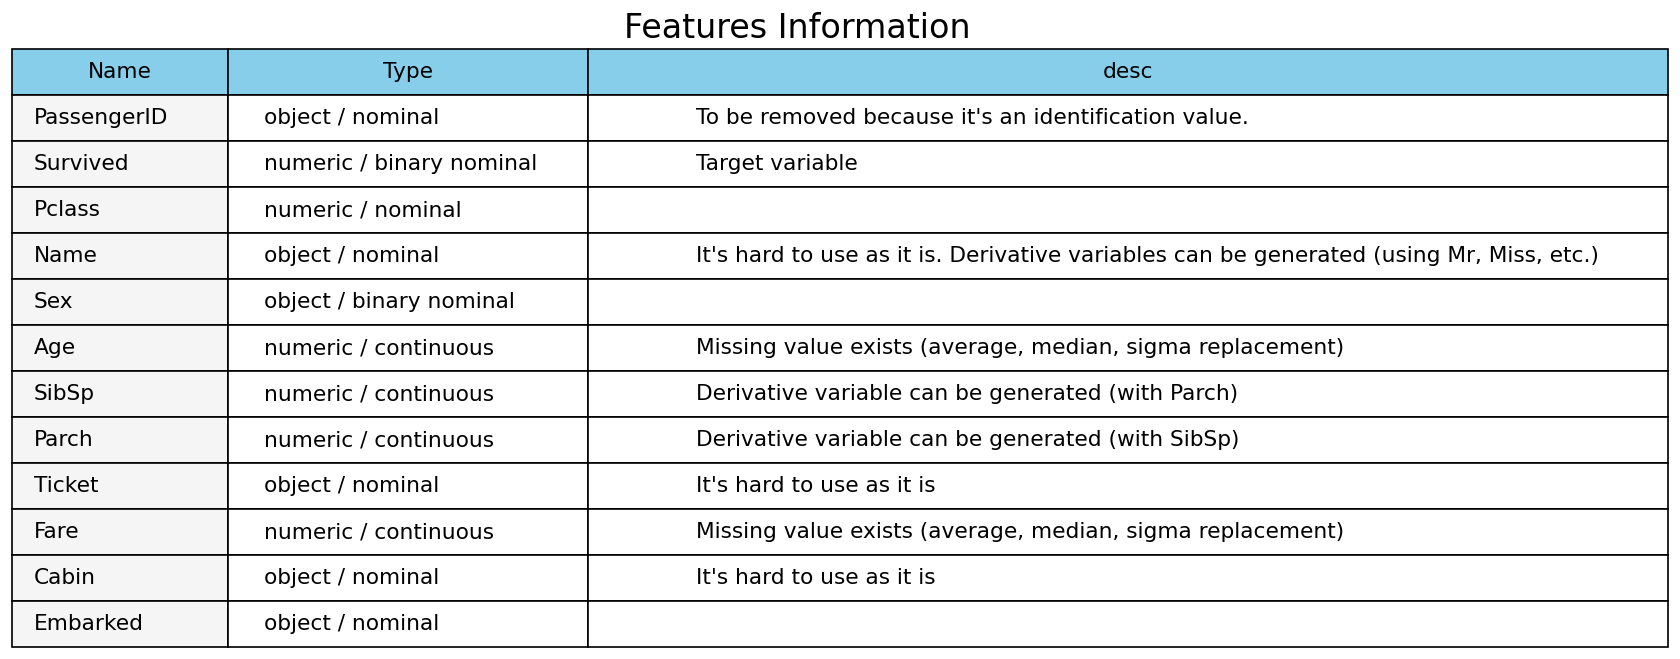

In [19]:
color_list=[['whitesmoke', 'white', 'white']]
fig = plt.figure()
ax = fig.add_axes([0,0,1,0.01])
ax.text(0.2, 2.3,'Features Information',size=20)
ax.axis('off')
table=ax.table(cellText = feature_table.values, colLabels=feature_table.columns,
                  colColours=['skyblue']*3, cellColours=color_list*12,
              colWidths=[.3,.5, 1.5], rowLoc='center', colLoc='center', cellLoc='left')
table.auto_set_font_size(False) 
table.set_fontsize(13)
table.scale(1.0, 2.3)
plt.show()

Cleansing - Outlier, Missing value

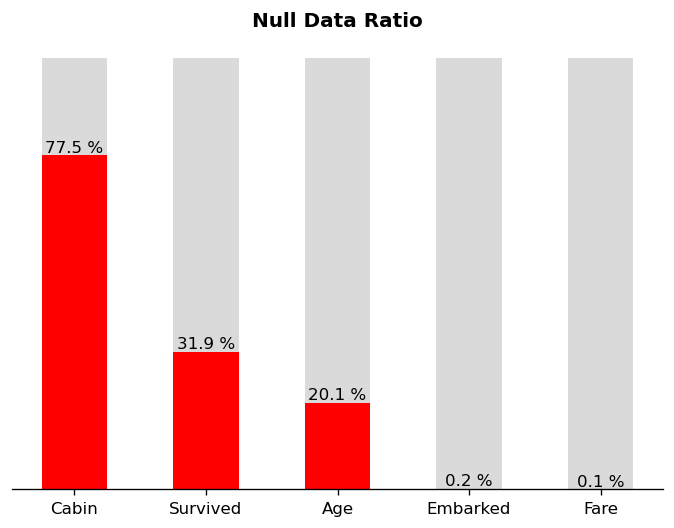

In [20]:
missing_table = show_missing(all_data)

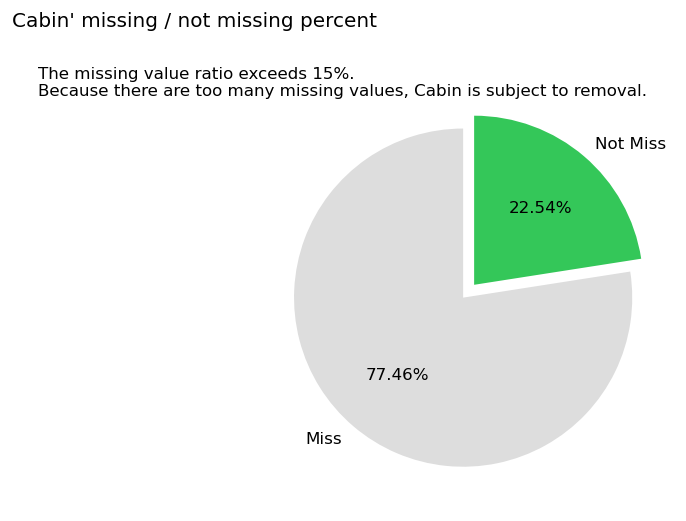

In [21]:
misspct = missing_table.iloc[0, 1]
notmisspct = 100 - misspct
missing_palette = ['#dddddd', mpl.colors.to_hex(light_palette[2])]

fig = plt.figure(figsize=(10, 5))
g = fig.add_gridspec(2,2)
ax = fig.add_subplot(g[:, 1])
ax.pie([misspct, notmisspct], labels=['Miss', 'Not Miss'],
      autopct='%.2f%%', explode=(0, 0.1), startangle=90, colors=missing_palette)
fig.suptitle("Cabin' missing / not missing percent", va='top', ha='center')
fig.text(0.37, .84, 'The missing value ratio exceeds 15%.\nBecause there are too many missing values, Cabin is subject to removal.',)
plt.show()

In [22]:
pd.pivot_table(train, values='Age', index=['Pclass'],
              columns=['Survived'], aggfunc=[np.mean, np.std]).style.bar(subset=['mean']).background_gradient(subset=['std'])

In [23]:
train_size = train.shape[0]
cabins = all_data.Cabin

all_data.drop(['Cabin'], axis=1, inplace=True)
#all_data['Age'] = all_data['Age'].fillna(all_data['Age'].median())
for c in [1, 2, 3]:
    for s in [0, 1]:
        all_data[(all_data.Pclass == c) & (all_data.Survived == s)]['Age'] =\
        all_data[(all_data.Pclass == c) & (all_data.Survived == s)].Age.fillna(
        all_data[(all_data.Pclass == c) & (all_data.Survived == s)].Age.mean())
all_data['Age'] = all_data['Age'].fillna(all_data['Age'].median())
all_data['Embarked'] = all_data['Embarked'].fillna(all_data['Embarked'].mode()[0])
all_data['Fare'] = all_data['Fare'].fillna(all_data['Fare'].median())

feature engineering - Add derivative features, Select features, Transform features

In [24]:
import re

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

all_data['Title'] = all_data.Name.apply(get_title)
#all_data['Age_bin'] = pd.cut(all_data.Age, 5)
all_data['Fare_bin'] = pd.qcut(all_data.Fare, 5)
def age_bin(num):
    for i in range(1, 100):
        if num < 10*i :  return f'{(i-1) * 10} ~ {i*10}'
all_data['Age_bin'] = all_data['Age'].apply(age_bin)
all_data['FamilySize'] = all_data.SibSp + all_data.Parch
all_data['IsAlone'] = all_data.FamilySize.apply(lambda x: 0 if x > 0 else 1)
all_data['HasCabin'] = cabins.apply(lambda x: 0 if type(x) == float else 1)

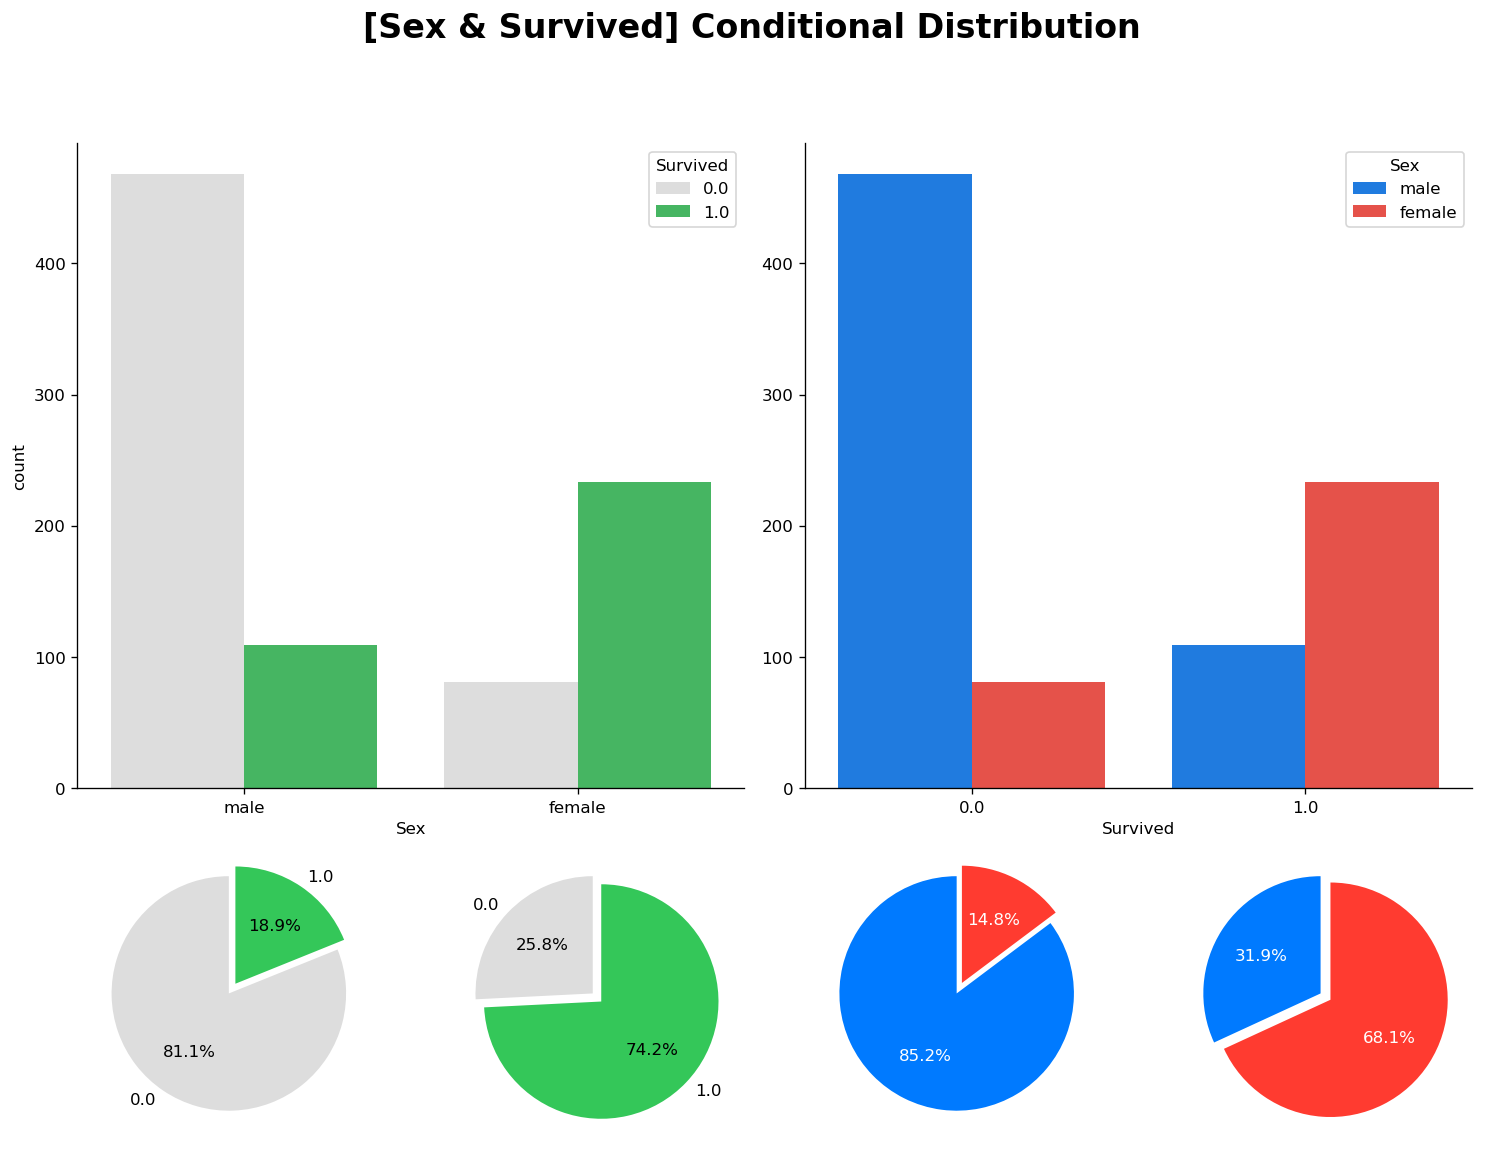

In [25]:
binary_to_binary(all_data, 'Sex', 'Survived')

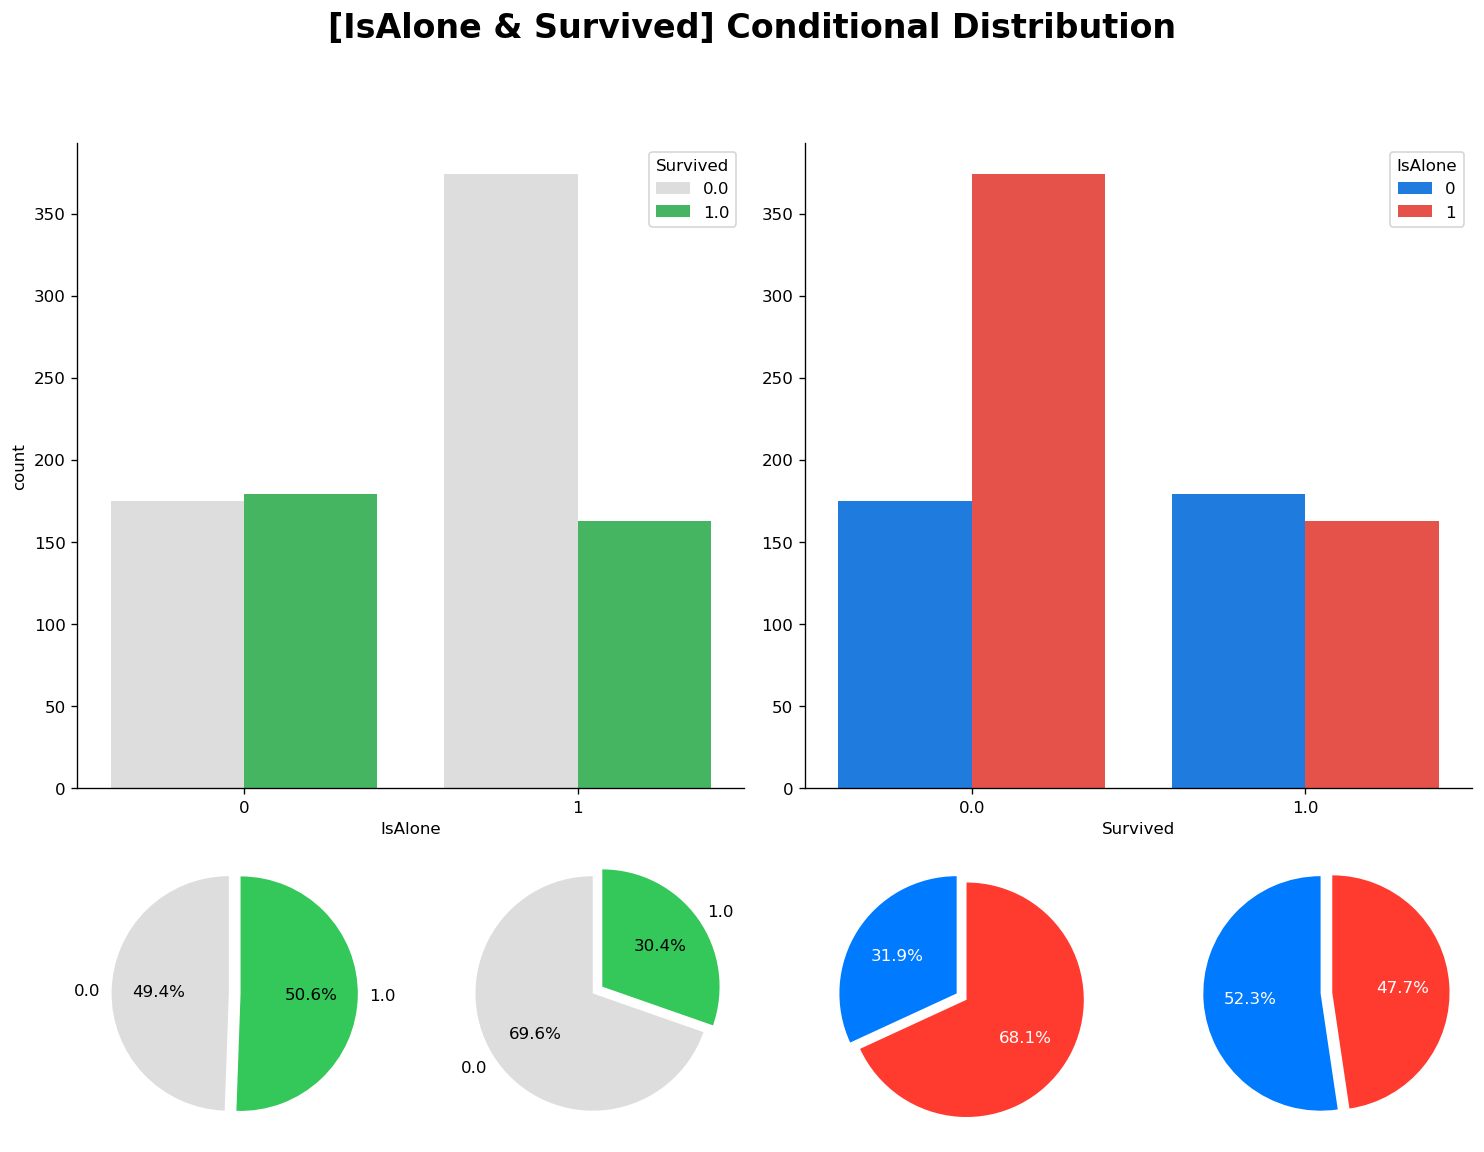

In [26]:
binary_to_binary(all_data, 'IsAlone', 'Survived')

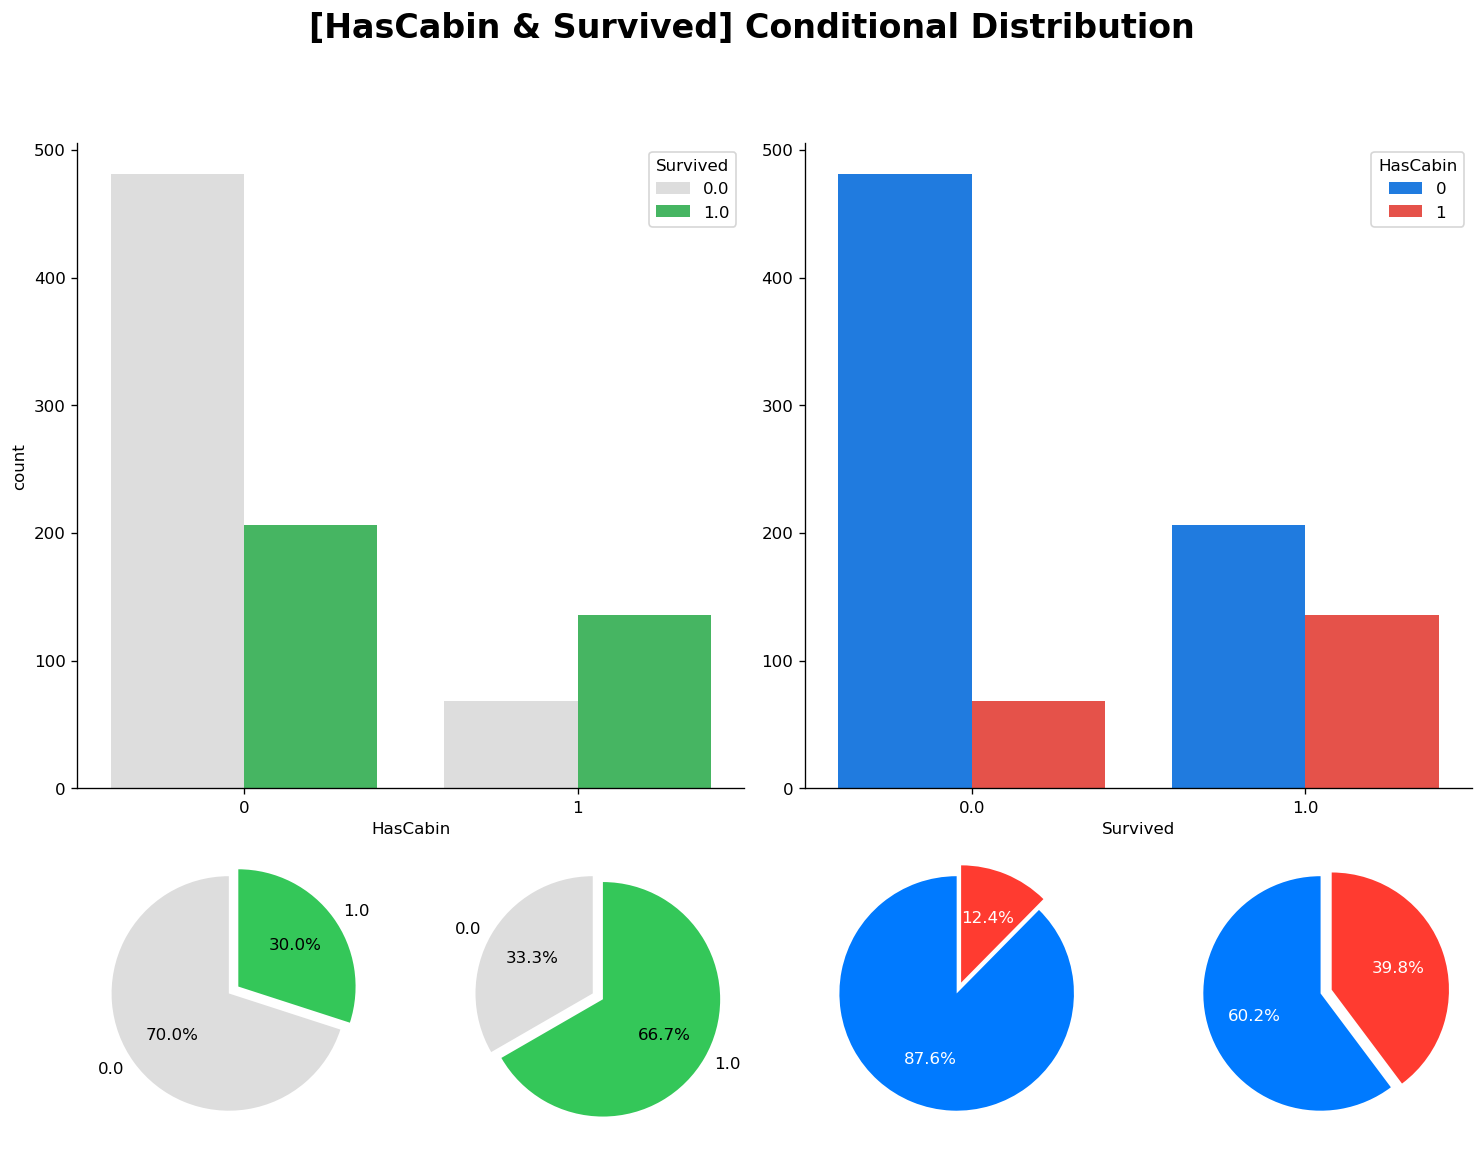

In [27]:
binary_to_binary(all_data, 'HasCabin', 'Survived')

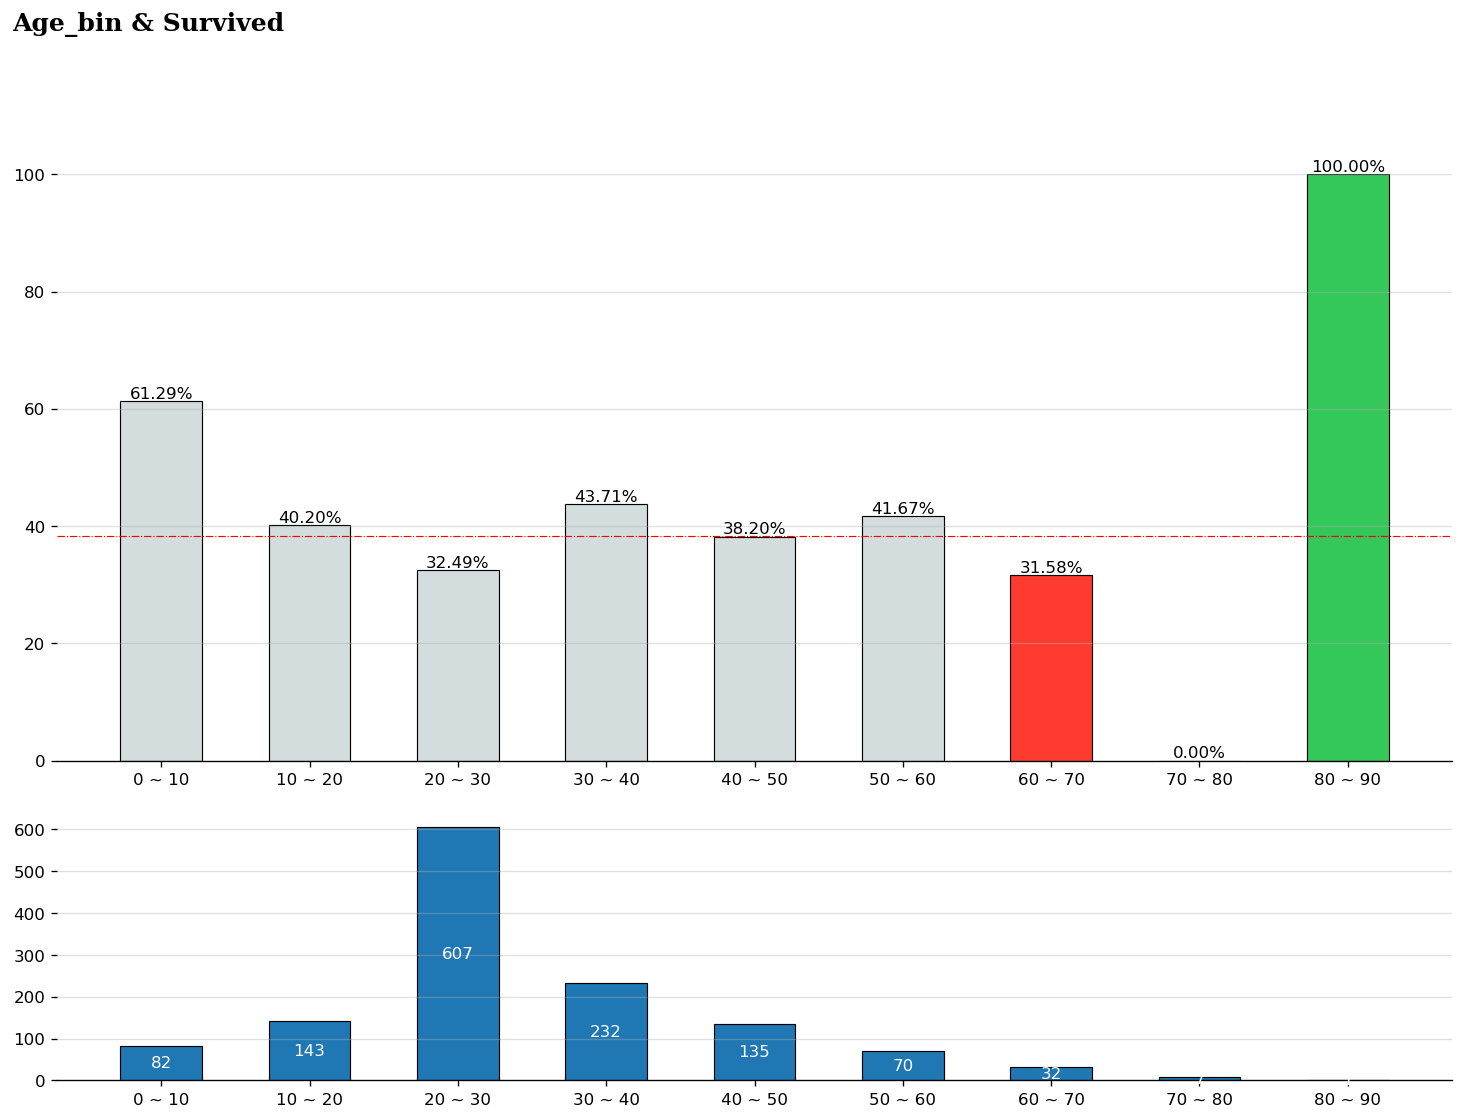

In [28]:
nominal_to_binary(all_data, 'Age_bin', 'Survived')

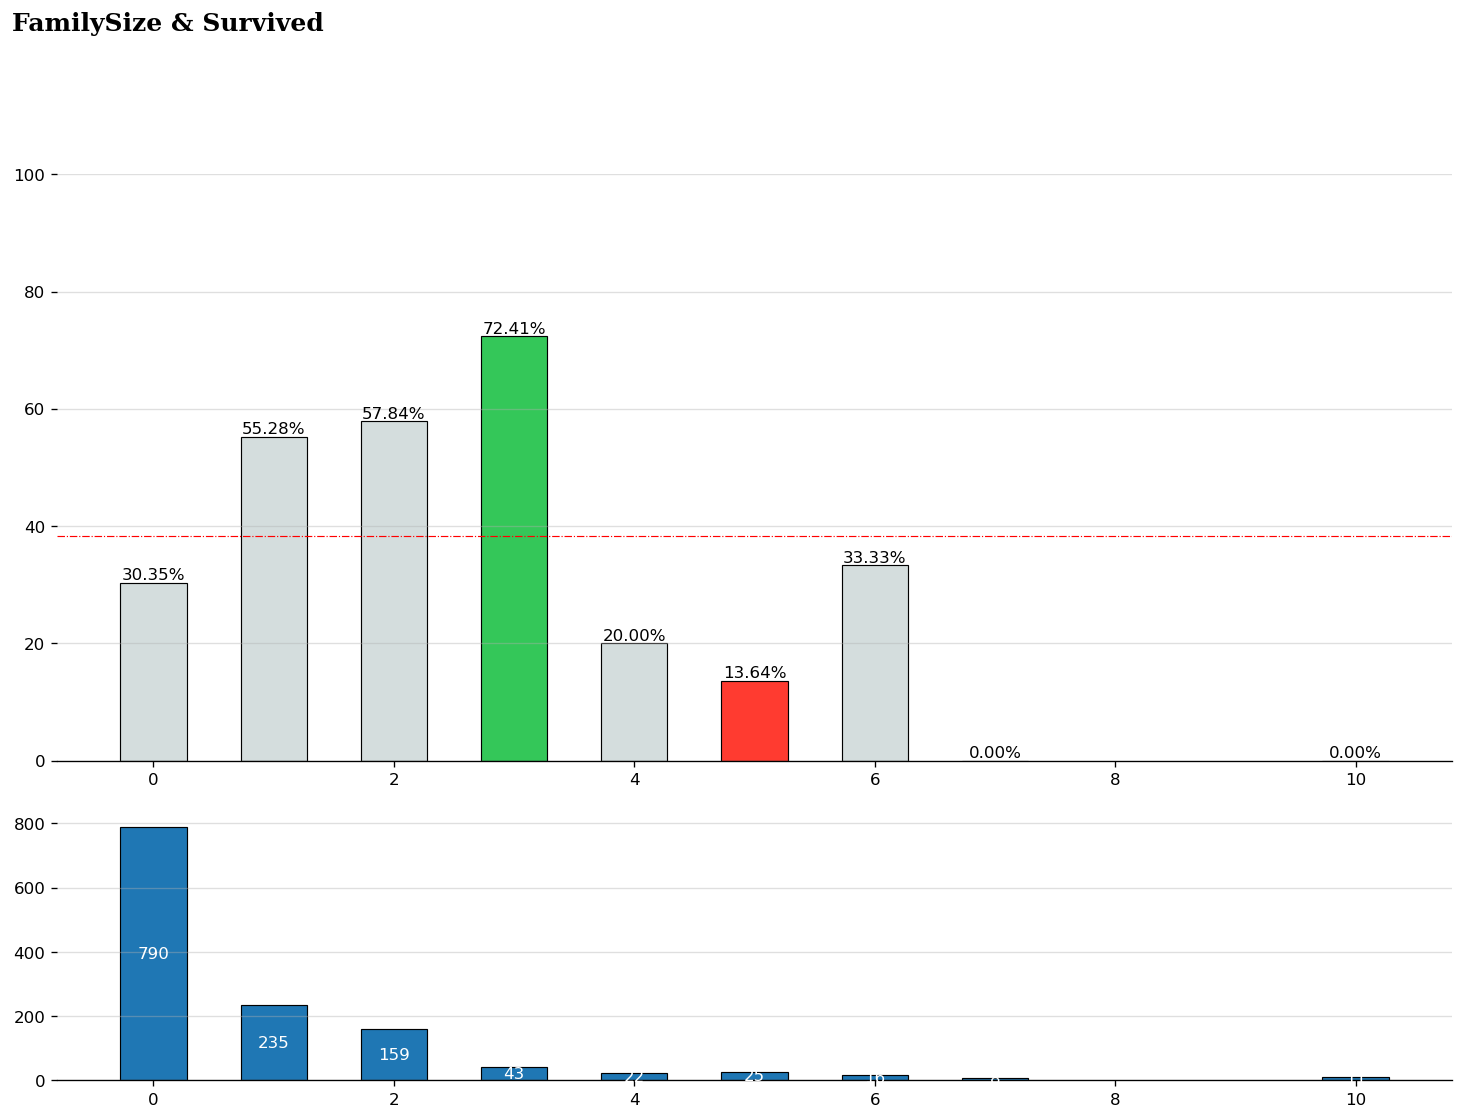

In [29]:
nominal_to_binary(all_data, 'FamilySize', 'Survived')

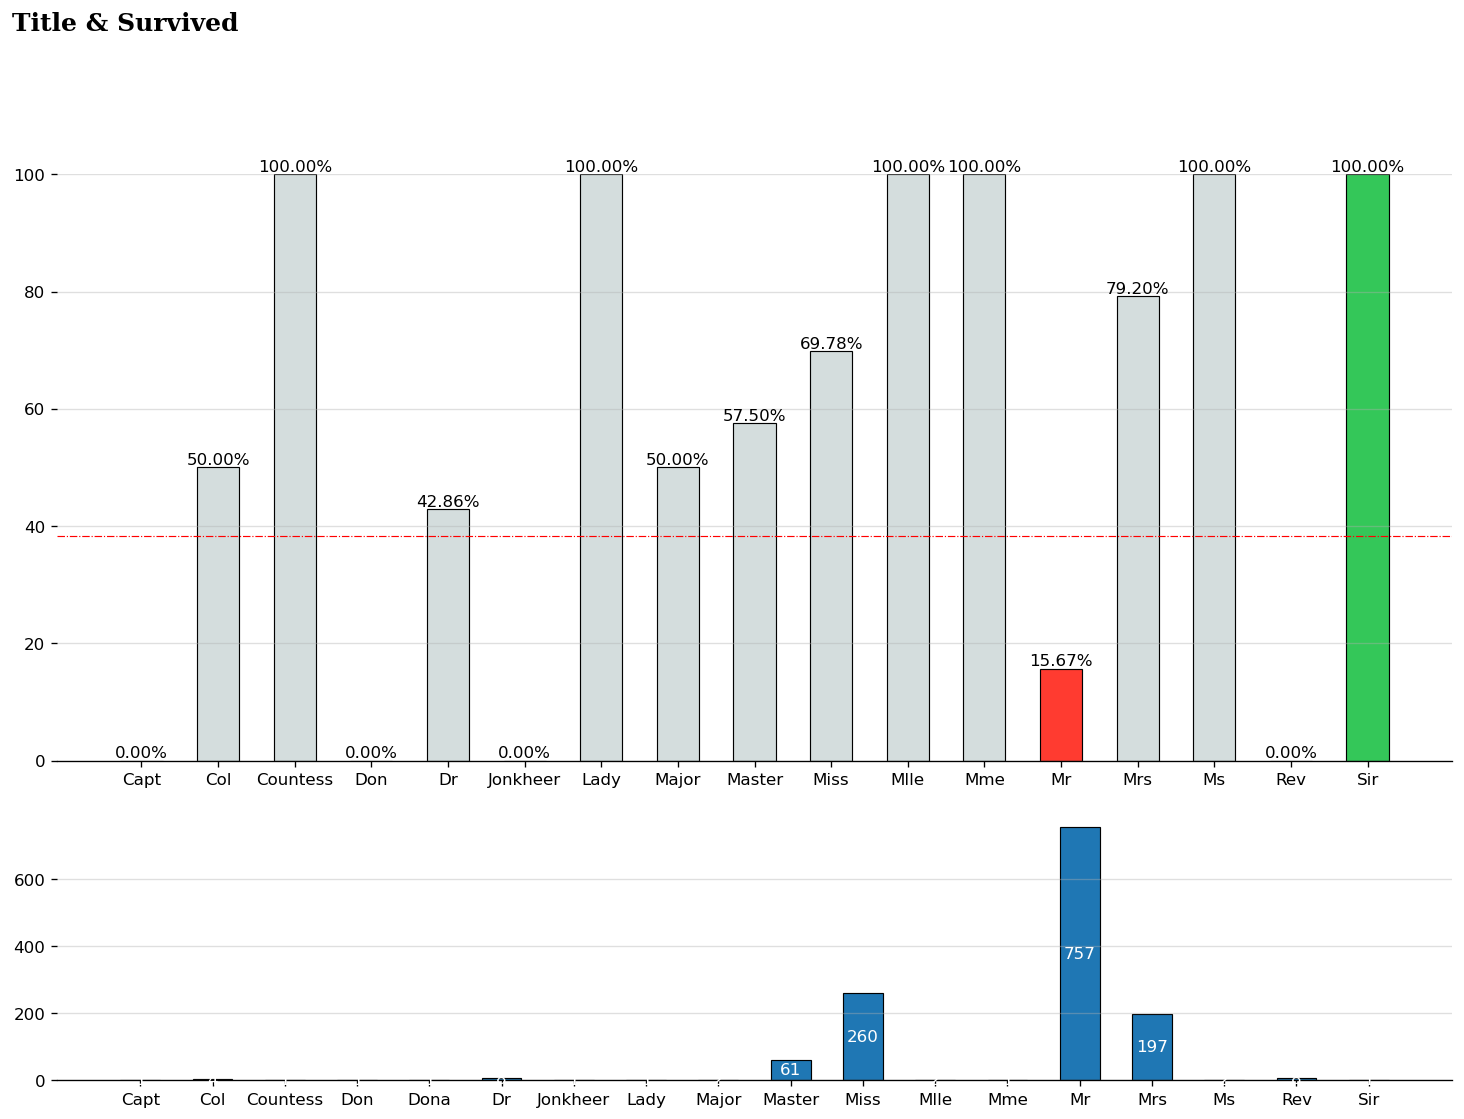

In [30]:
nominal_to_binary(all_data, 'Title', 'Survived')

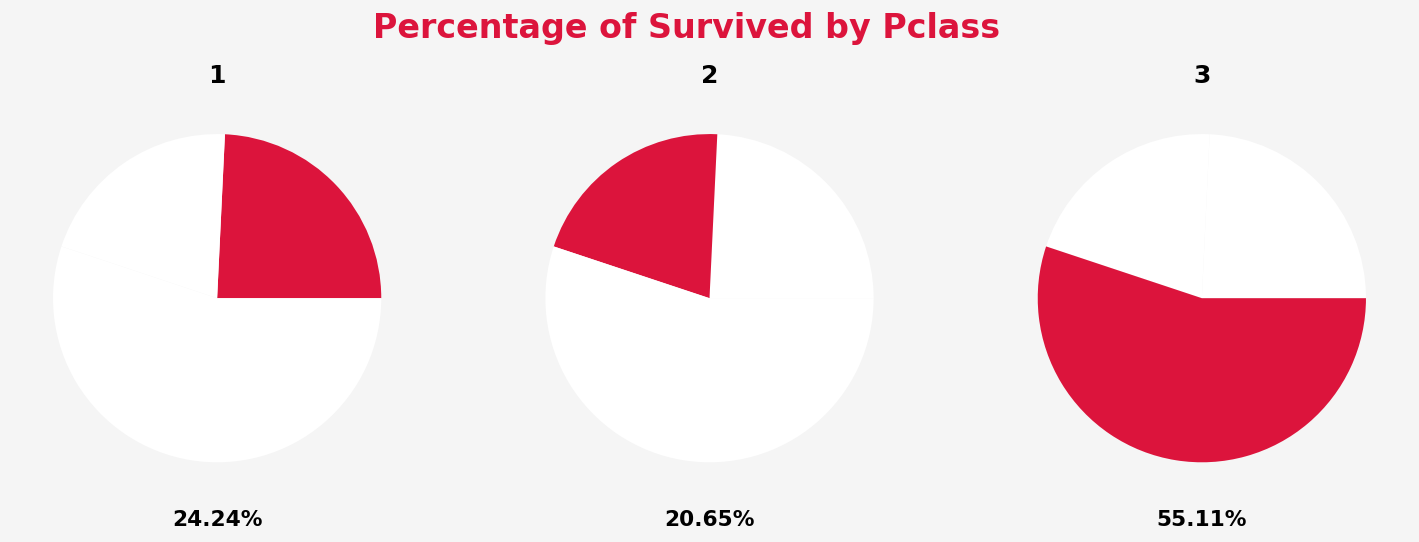

In [31]:
piechart(all_data.groupby('Pclass').Survived.count(),
         std_name='Pclass', sub_name='Survived',
         xsize=15)

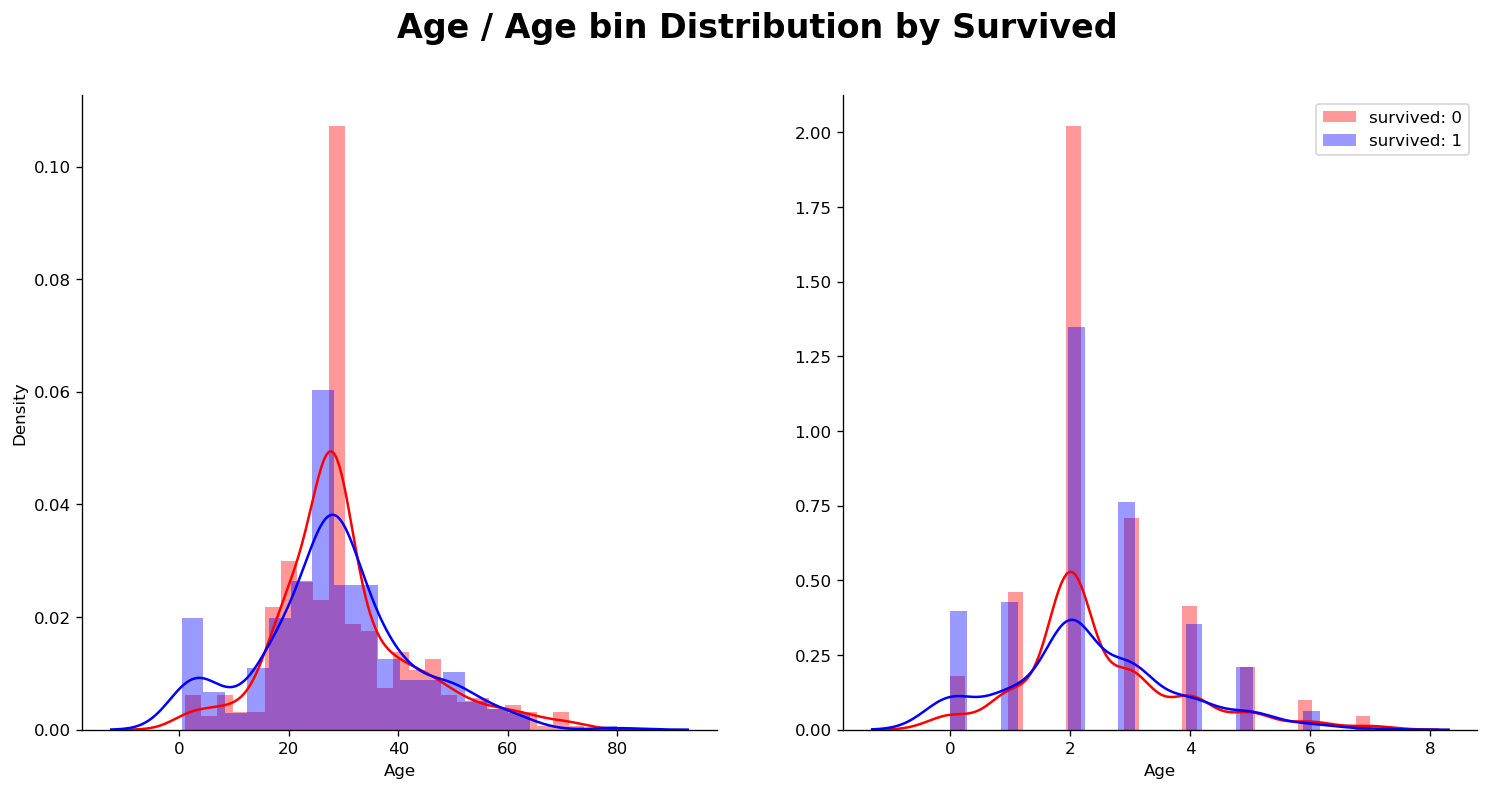

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.distplot(all_data[all_data['Survived']==0]['Age'], label='survived: 0', ax=ax[0], color='red')
sns.distplot(all_data[all_data['Survived']==1]['Age'], label='survived: 1', ax=ax[0], color='blue')
sns.distplot(LabelEncoder().fit_transform(all_data[all_data['Survived']==0]['Age_bin']), label='survived: 0', ax=ax[1], color='red')
sns.distplot(LabelEncoder().fit_transform(all_data[all_data['Survived']==1]['Age_bin']), label='survived: 1', ax=ax[1], color='blue')
ax[1].set_xlabel('Age')
ax[1].set_ylabel('')
plt.legend()
fig.suptitle('Age / Age bin Distribution by Survived', weight='bold', size=20)
plt.show()

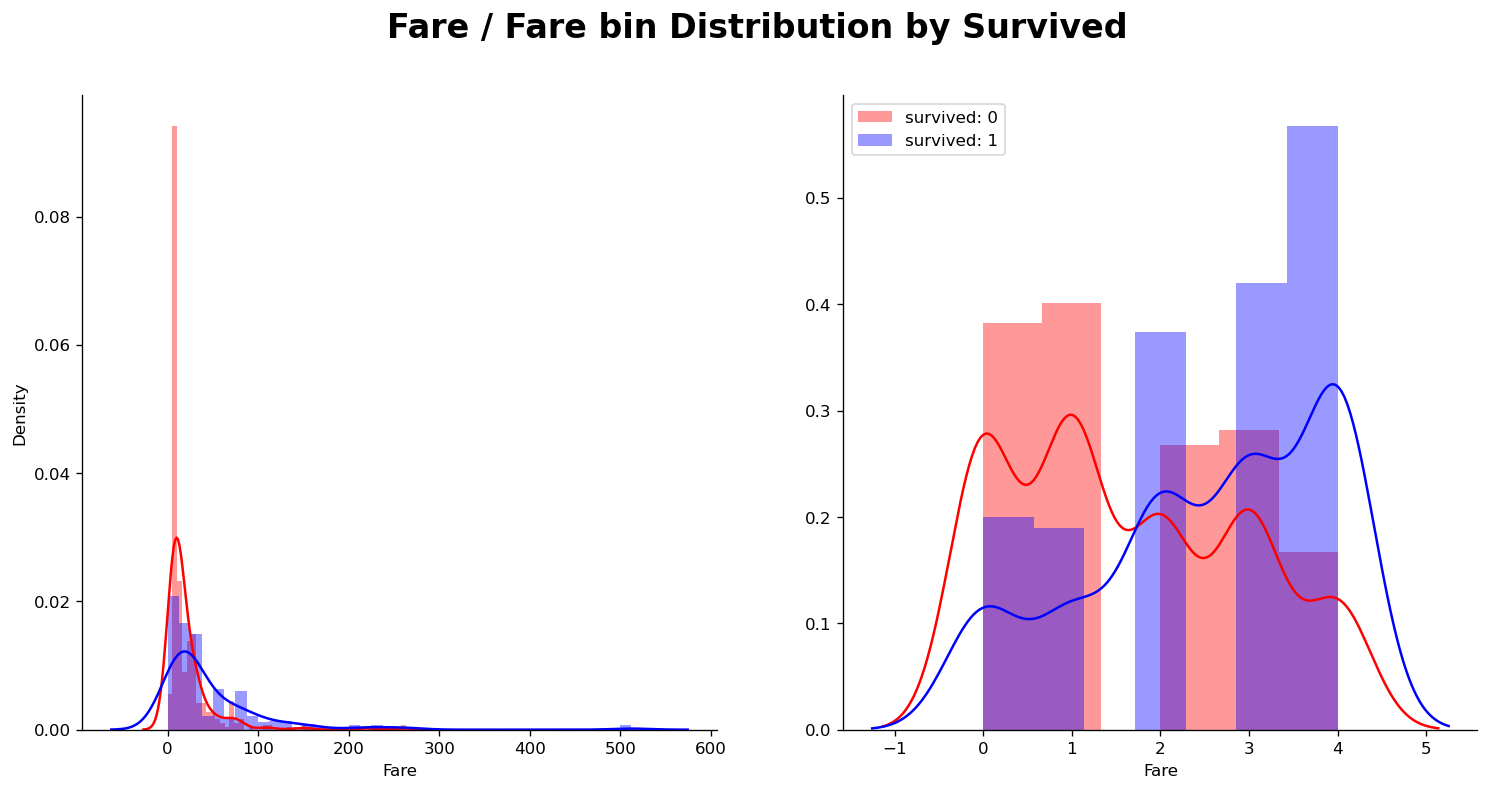

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.distplot(all_data[all_data['Survived']==0]['Fare'], label='survived: 0', ax=ax[0], color='red')
sns.distplot(all_data[all_data['Survived']==1]['Fare'], label='survived: 1', ax=ax[0], color='blue')
sns.distplot(LabelEncoder().fit_transform(all_data[all_data['Survived']==0]['Fare_bin']), label='survived: 0', ax=ax[1], color='red')
sns.distplot(LabelEncoder().fit_transform(all_data[all_data['Survived']==1]['Fare_bin']), label='survived: 1', ax=ax[1], color='blue')
ax[1].set_xlabel('Fare')
ax[1].set_ylabel('')
plt.legend()
fig.suptitle('Fare / Fare bin Distribution by Survived', weight='bold', size=20)

plt.show()

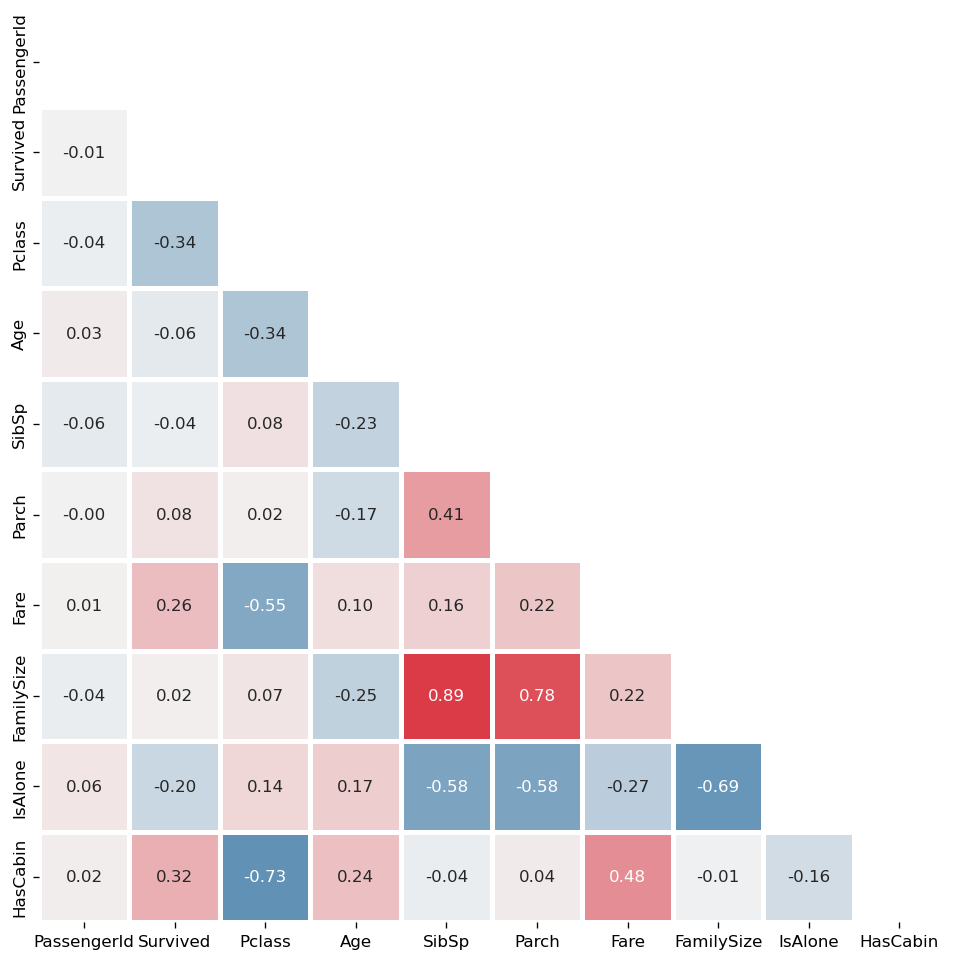

In [34]:
plt.subplots(figsize=(10, 10))
drawcorr(all_data.iloc[:train_size])

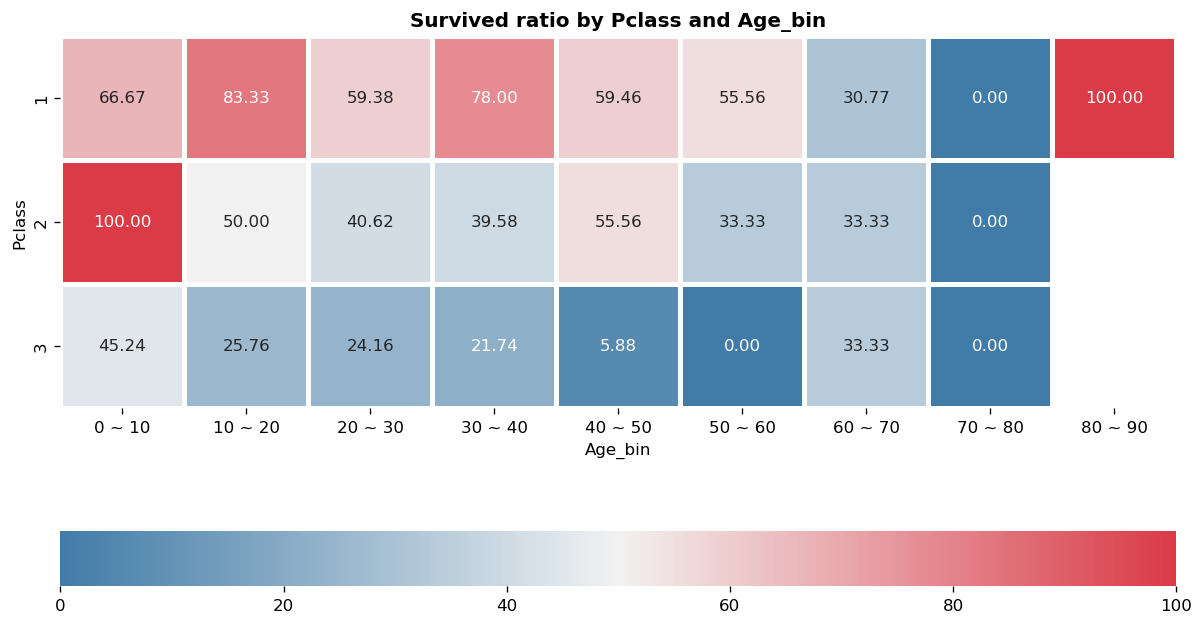

In [35]:
plt.subplots(figsize=(12, 9))
binary_by_categoricals(all_data, 'Pclass', 'Age_bin', 'Survived')

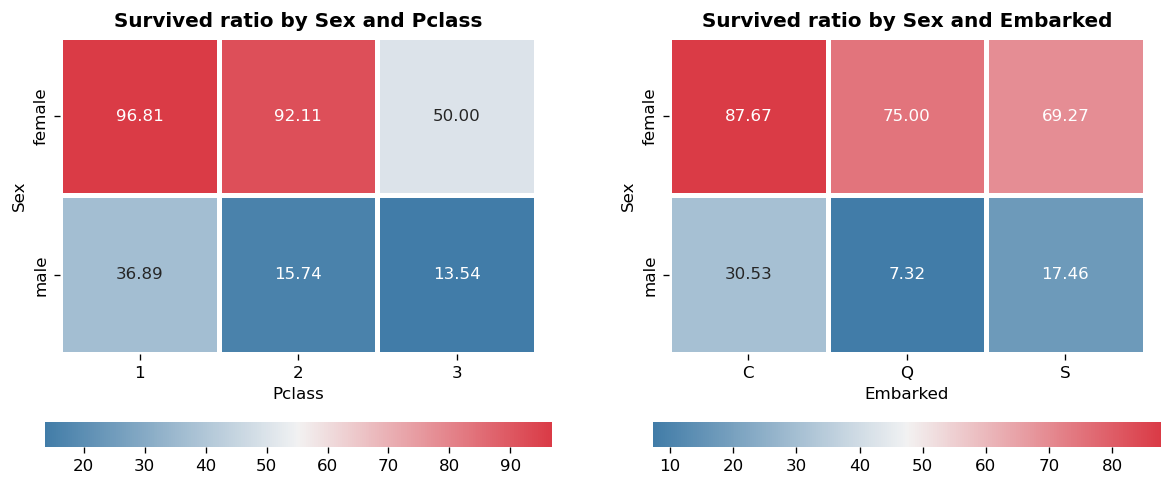

In [36]:
f, ax = plt.subplots(1, 2, figsize=(12, 5))
binary_by_categoricals(all_data, 'Sex', 'Pclass', 'Survived', ax[0])
binary_by_categoricals(all_data, 'Sex', 'Embarked', 'Survived', ax[1])
plt.show()

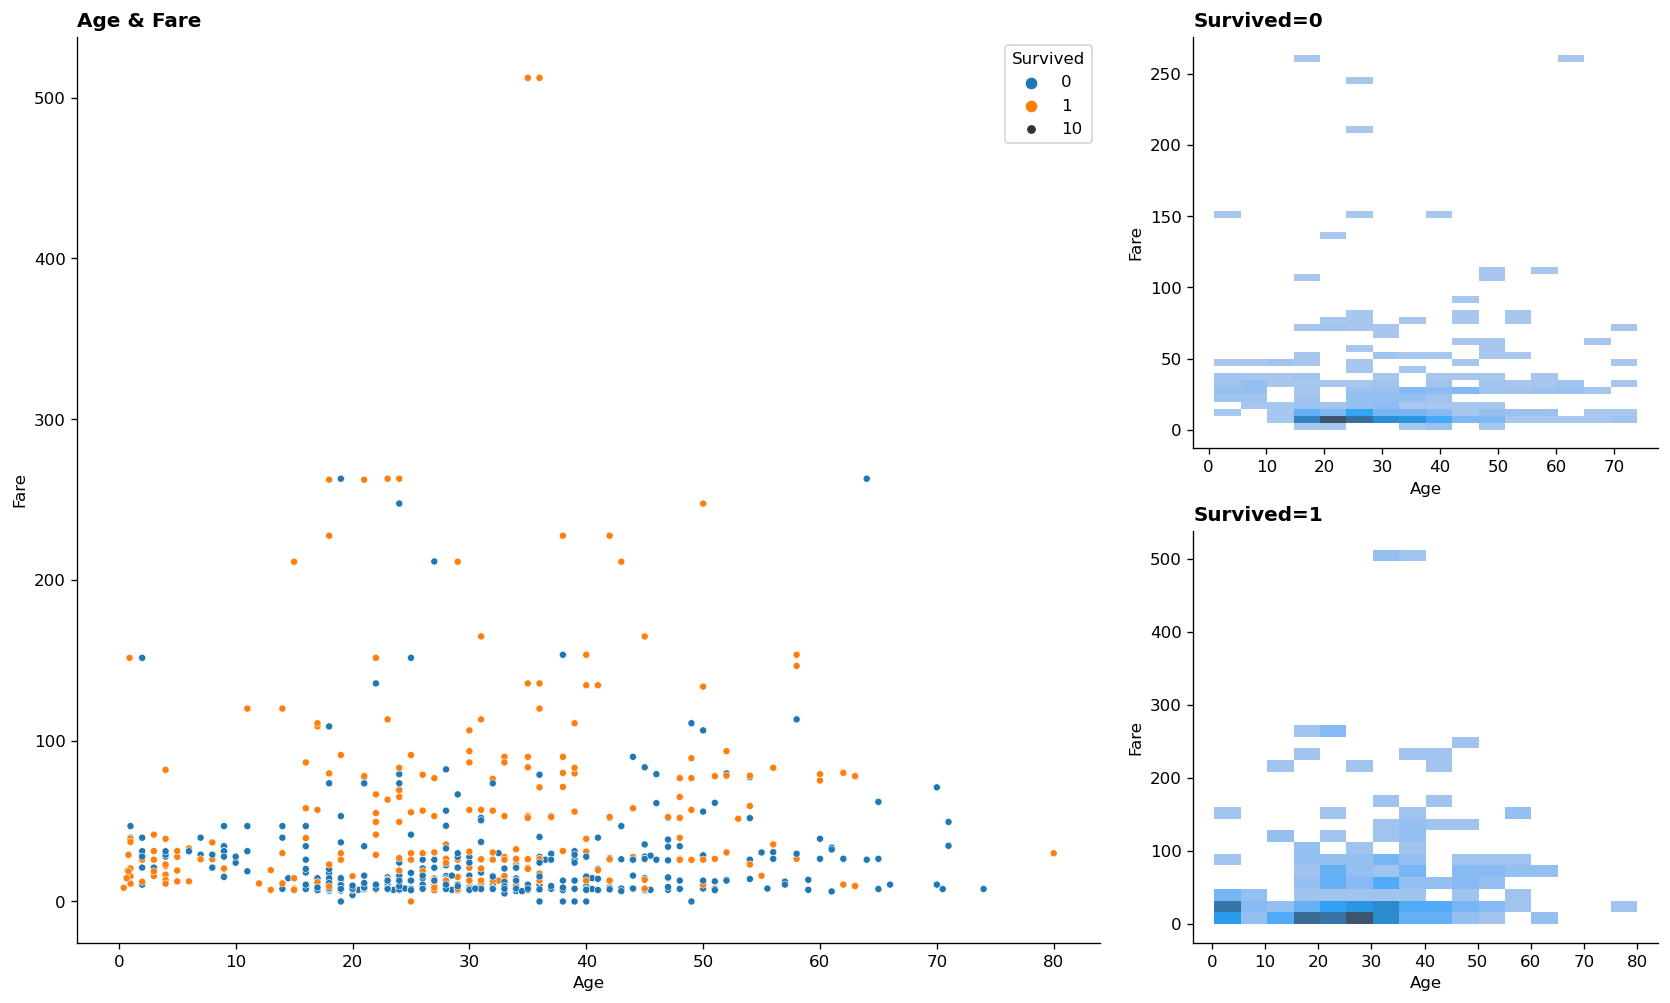

In [37]:
scatter_by_binary(train, 'Age', 'Fare', 'Survived')

In [38]:
drop_features = [
    'PassengerId', 'Name', 'SibSp', 'Ticket'
]
all_data.drop(drop_features, axis=1, inplace=True)

In [39]:
nominals = [
    'Sex', 'Embarked', 'Title'
]
orders = [
    'Age_bin', 'Fare_bin'
]
le = LabelEncoder()
for f in orders:
    all_data[f] = le.fit_transform(all_data[f])

In [40]:
train = all_data.iloc[:train_size, :]
test = all_data.iloc[train_size:, :]

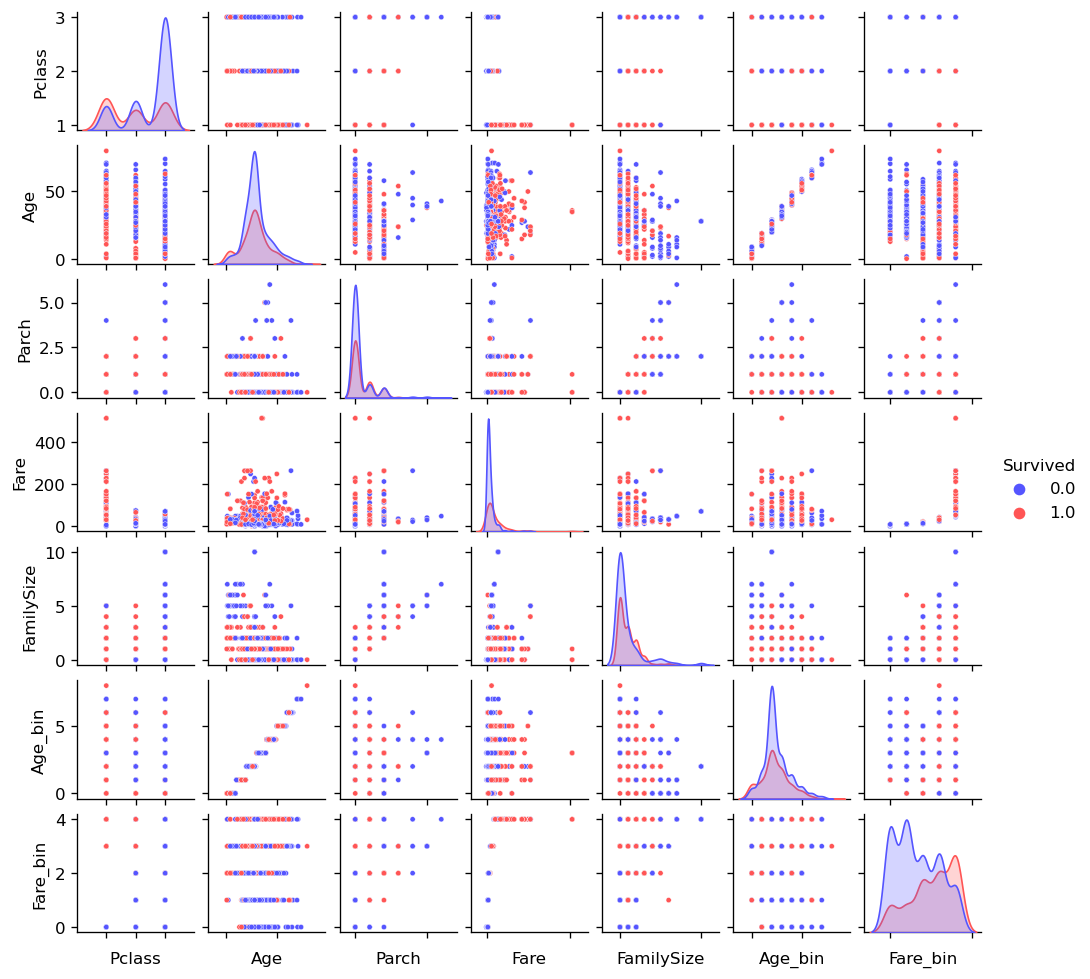

In [41]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title', u'Age_bin', u'Fare_bin']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])
plt.show()

In [42]:
all_data = pd.get_dummies(all_data)

In [43]:
train = all_data.iloc[:train_size, :]
X_test = all_data.iloc[train_size:, :].drop(['Survived'], axis=1)

Modeling

In [44]:
X_train, y_train = train.drop(['Survived'], axis=1), train.Survived.values

In [45]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear'
    }

In [76]:
model_logistic = LogisticRegression()
model_rfc = rfc()
model_etc = ExtraTreesClassifier()
model_abc = AdaBoostClassifier(DecisionTreeClassifier())
model_gbc = gbc()
model_svc = SVC(**svc_params, probability=True)
model_xgb = XGBClassifier()
model_lgbm = LGBMClassifier()

models = {
    'Logistic Regresison': model_logistic,
    'Random Forest': model_rfc,
    'ExtraTrees': model_etc,
    'AdaBoost': model_abc, 
    'GradientBoost': model_gbc,
    'SVC': model_svc,
    'XGBoost': model_xgb,
    'LightGBM': model_lgbm
}
validation_scores = {}

In [47]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    print(f"{name}'s KFold Start")
    score = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=kf, n_jobs=-1, verbose=0).mean()
    print(f"{name}'s cross validation score: {score:.6f}\n")
    validation_scores[name] = score

Logistic Regresison's KFold Start
Logistic Regresison's cross validation score: 0.828284

Random Forest's KFold Start
Random Forest's cross validation score: 0.818172

ExtraTrees's KFold Start
ExtraTrees's cross validation score: 0.800201

AdaBoost's KFold Start
AdaBoost's cross validation score: 0.803609

GradientBoost's KFold Start
GradientBoost's cross validation score: 0.826062

SVC's KFold Start
SVC's cross validation score: 0.824926

XGBoost's KFold Start
XGBoost's cross validation score: 0.820444

LightGBM's KFold Start
LightGBM's cross validation score: 0.827173



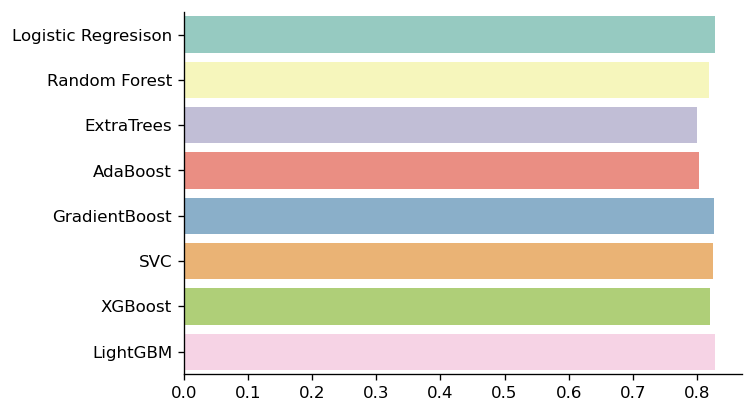

In [48]:
sns.barplot(y=list(validation_scores.keys()), 
            x=list(validation_scores.values()),
            orient='h', palette="Set3")
plt.show()

In [77]:
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

etc_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

abc_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gbc_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

models_params = {
    'Random Forest': [model_rfc, rf_param_grid],
    'ExtraTrees': [model_etc, etc_param_grid],
    'AdaBoost': [model_abc, abc_param_grid], 
    'GradientBoost': [model_gbc, gbc_param_grid],
    'SVC': [model_svc, svc_param_grid],
}
final_models = {
    
}

In [78]:
for name, [model, param] in models_params.items():
    print(f'{name} grid search start')
    search = GridSearchCV(model, param, cv=kf, n_jobs=-1, verbose=1,
                         scoring='accuracy').fit(X_train, y_train)
    final_models[name] = search.best_estimator_
    print(f'best score: {search.best_score_}\n')

Random Forest grid search start
Fitting 5 folds for each of 54 candidates, totalling 270 fits
best score: 0.8406503044378884

ExtraTrees grid search start
Fitting 5 folds for each of 54 candidates, totalling 270 fits
best score: 0.8383842822170611

AdaBoost grid search start
Fitting 5 folds for each of 112 candidates, totalling 560 fits
best score: 0.8069487163392128

GradientBoost grid search start
Fitting 5 folds for each of 72 candidates, totalling 360 fits
best score: 0.8339087314041805

SVC grid search start
Fitting 5 folds for each of 28 candidates, totalling 140 fits
best score: 0.8136714581633292



In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
for name, model in final_models.items():
    plot_learning_curve(model, name, X_train, y_train, cv=kf)

In [92]:
model_voting = VotingClassifier(estimators=[('rfc', final_models['Random Forest']), ('ebc', final_models['ExtraTrees']),
('svc', final_models['SVC']), ('abc',final_models['AdaBoost']),('gbc',final_models['GradientBoost'])], voting='soft', n_jobs=-1)

In [91]:
# best score model.
test_Survived = pd.Series(final_models['Random Forest'].predict(X_test), name="Survived").astype('int')
results = pd.concat([test_id, test_Survived],axis=1)
results.to_csv("submission.csv",index=False)